# `CLOUD.jl` - 2D linear advection

In [24]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_dgsem_2D/"
results_path = "../results/advection_dgsem_2D/";

Define the physical problem

In [25]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=0.0);

Set up a DGSEM scheme of degree `p` with `M` elements

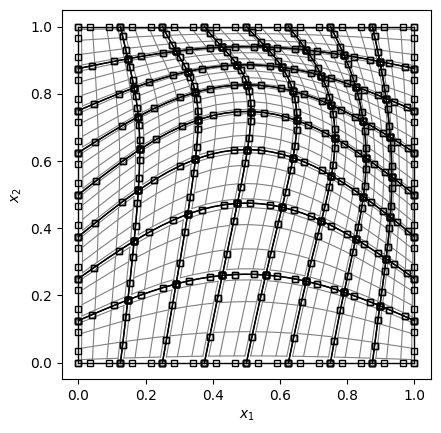

In [26]:
M = 8
p = 3
p_map = p
form = WeakConservationForm(CreanMapping())

reference_approximation =ReferenceApproximation(
    DGSEM(p), Quad(),
    volume_quadrature_rule=LGQuadrature(),
    facet_quadrature_rule=LGLQuadrature(),mapping_degree=p_map,
    N_plot=ceil(Int,50/M))
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.15)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf",
    plot_volume_nodes=false, grid_lines=true)

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [27]:
reset_timer!()
n_s = 2
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false,
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final")

Visualize the solution

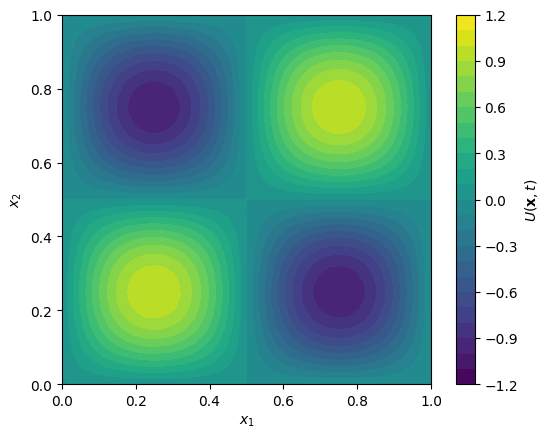

In [28]:
plotter = Plotter(spatial_discretization, plots_path)
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

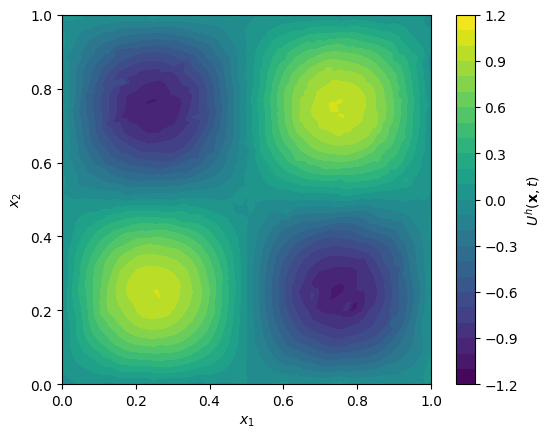

In [29]:
visualize(last(sol.u),plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25, 
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [30]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.012312199720777345]
Conservation (initial/final/diff):
[9.397716764936864e-10][9.397700781628437e-10][-1.5983308426781306e-15]
Energy (initial/final/diff):
[0.24999982249459424][0.24999982249458375][-1.049160758270773e-14]


In [31]:
check_sbp_property(reference_approximation)

(0.7799184705041492, 0.7799184705041488)